# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 1

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device

device(type='cuda', index=1)

# Prepare data

## Dataset

In [5]:
ds = 'Shuffle'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'Haibin',
                        'data_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([58000, 9]), torch.Size([58000]), 58000, 9, 7)

## Pseudo-electrical Signal

In [7]:
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.2323, 0.4893, 0.4375, 0.5070, 0.3462, 0.6381, 0.4902, 0.6437, 0.6077],
        [0.2828, 0.4872, 0.5547, 0.5070, 0.3013, 0.6387, 0.5490, 0.7143, 0.6624],
        [0.2626, 0.4872, 0.4766, 0.5070, 0.3846, 0.6380, 0.5033, 0.6148, 0.5756],
        [0.1010, 0.4872, 0.4297, 0.5070, 0.3462, 0.6385, 0.5752, 0.6437, 0.5852],
        [0.1010, 0.4872, 0.4531, 0.5070, 0.3558, 0.6375, 0.5948, 0.6404, 0.5756],
        [0.5859, 0.4872, 0.5234, 0.5065, 0.3109, 0.6381, 0.3333, 0.6998, 0.7010],
        [0.2929, 0.4872, 0.4688, 0.5070, 0.2949, 0.6384, 0.4771, 0.7047, 0.6720],
        [0.2828, 0.4871, 0.5781, 0.5066, 0.3878, 0.6380, 0.5752, 0.6324, 0.5756],
        [0.2626, 0.4880, 0.4375, 0.5070, 0.3462, 0.6381, 0.4641, 0.6437, 0.6109],
        [0.1010, 0.4872, 0.6250, 0.5061, 0.3462, 0.6381, 0.7320, 0.6838, 0.5852]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(4096, int(E*train_rate))
E_test = min(1024, int(E*test_rate))
E_valid = min(1024, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(4096, 1024, 1024)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 3
m = 0.3
T = 0.1
M_train = 100
K_train = 20
M_test = 20
K_test = 10

# Normal NN

## Define

In [12]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=9, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=7, bias=True)
  (3): Tanh()
)

## Training

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.80371 | Loss: 1.625954032
| Epoch:   500 | Accuracy: 0.91699 | Loss: 0.672137976
| Epoch:  1000 | Accuracy: 0.91602 | Loss: 0.662190080
| Epoch:  1500 | Accuracy: 0.91699 | Loss: 0.658846378
| Epoch:  2000 | Accuracy: 0.91699 | Loss: 0.657235920
| Epoch:  2500 | Accuracy: 0.91699 | Loss: 0.656301081
| Epoch:  3000 | Accuracy: 0.91699 | Loss: 0.655686915
| Epoch:  3500 | Accuracy: 0.91699 | Loss: 0.655458093
| Epoch:  4000 | Accuracy: 0.91992 | Loss: 0.651467919
| Epoch:  4500 | Accuracy: 0.93164 | Loss: 0.635364652
| Epoch:  5000 | Accuracy: 0.93457 | Loss: 0.633547604
| Epoch:  5500 | Accuracy: 0.93457 | Loss: 0.632523417
| Epoch:  6000 | Accuracy: 0.93457 | Loss: 0.631898046
| Epoch:  6500 | Accuracy: 0.93457 | Loss: 0.631520033
| Epoch:  7000 | Accuracy: 0.93457 | Loss: 0.631048620
| Epoch:  7500 | Accuracy: 0.93457 | Loss: 0.630657494
| Epoch:  8000 | Accuracy: 0.93457 | Loss: 0.630334020
| Epoch:  8500 | Accuracy: 0.93457 | Loss: 0.630065024
| Epoch:  

(15765, 0.6283419728279114)

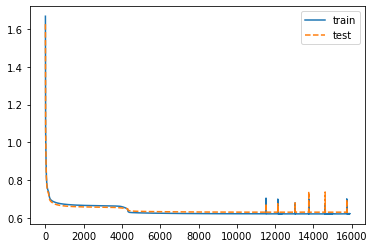

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [15]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.92090 | Loss: 0.653248847
| Epoch:   500 | Accuracy: 0.93457 | Loss: 0.629341006
| Epoch:  1000 | Accuracy: 0.93457 | Loss: 0.629361749
| Epoch:  1500 | Accuracy: 0.93457 | Loss: 0.629376948
| Epoch:  2000 | Accuracy: 0.93457 | Loss: 0.629394650
| Epoch:  2500 | Accuracy: 0.93457 | Loss: 0.629415452
| Epoch:  3000 | Accuracy: 0.93457 | Loss: 0.629438698
| Epoch:  3500 | Accuracy: 0.93457 | Loss: 0.628976345
| Epoch:  4000 | Accuracy: 0.93457 | Loss: 0.629489779
| Epoch:  4500 | Accuracy: 0.93457 | Loss: 0.629484773
| Epoch:  5000 | Accuracy: 0.93457 | Loss: 0.629482985
Early stop.
Finished.


(3455, 0.628265380859375)

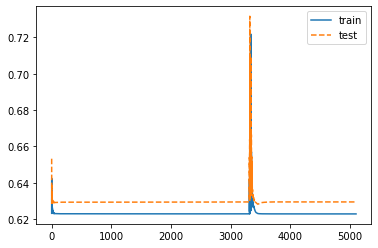

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [17]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.005)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.93164 | Loss: 0.631837964
| Epoch:   500 | Accuracy: 0.93457 | Loss: 0.629479349
| Epoch:  1000 | Accuracy: 0.93457 | Loss: 0.629471898
| Epoch:  1500 | Accuracy: 0.93457 | Loss: 0.629475355
| Epoch:  2000 | Accuracy: 0.93457 | Loss: 0.629479706
| Epoch:  2500 | Accuracy: 0.93457 | Loss: 0.629485846
| Epoch:  3000 | Accuracy: 0.93457 | Loss: 0.629493594
| Epoch:  3500 | Accuracy: 0.93457 | Loss: 0.629503012
| Epoch:  4000 | Accuracy: 0.93457 | Loss: 0.629514217
| Epoch:  4500 | Accuracy: 0.93457 | Loss: 0.629390597
| Epoch:  5000 | Accuracy: 0.93457 | Loss: 0.629499197
Early stop.
Finished.


(1, 0.628269374370575)

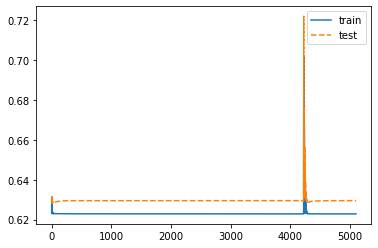

In [18]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [19]:
with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [20]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.9365234375


In [21]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=9, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=7, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [22]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [23]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.00000 | Loss: 0.864596009 |
| Epoch:   500 | Accuracy: 0.97168 | Loss: 0.047006421 |
| Epoch:  1000 | Accuracy: 0.98145 | Loss: 0.032318532 |
| Epoch:  1500 | Accuracy: 0.98340 | Loss: 0.027903851 |
| Epoch:  2000 | Accuracy: 0.98340 | Loss: 0.026293054 |
| Epoch:  2500 | Accuracy: 0.98340 | Loss: 0.026383754 |
| Epoch:  3000 | Accuracy: 0.99219 | Loss: 0.025149310 |
| Epoch:  3500 | Accuracy: 0.99219 | Loss: 0.024196202 |
| Epoch:  4000 | Accuracy: 0.98340 | Loss: 0.026989564 |
| Epoch:  4500 | Accuracy: 0.99219 | Loss: 0.022781981 |
| Epoch:  5000 | Accuracy: 0.99219 | Loss: 0.021981405 |
| Epoch:  5500 | Accuracy: 0.99512 | Loss: 0.021243721 |
Early stop.
Finished.


(5773, 0.019937513396143913)

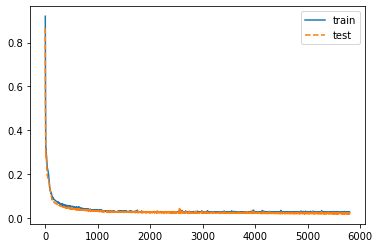

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [25]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.97168 | Loss: 0.062950194 |
| Epoch:   500 | Accuracy: 0.99219 | Loss: 0.020844538 |
| Epoch:  1000 | Accuracy: 0.99219 | Loss: 0.021994229 |
| Epoch:  1500 | Accuracy: 0.99219 | Loss: 0.020480750 |
| Epoch:  2000 | Accuracy: 0.99512 | Loss: 0.021843653 |
| Epoch:  2500 | Accuracy: 0.99219 | Loss: 0.021737698 |
| Epoch:  3000 | Accuracy: 0.99219 | Loss: 0.020533042 |
| Epoch:  3500 | Accuracy: 0.99219 | Loss: 0.021319099 |
| Epoch:  4000 | Accuracy: 0.99219 | Loss: 0.023167055 |
| Epoch:  4500 | Accuracy: 0.99219 | Loss: 0.020534469 |
| Epoch:  5000 | Accuracy: 0.99316 | Loss: 0.020169981 |
Early stop.
Finished.


(4703, 0.019641900435090065)

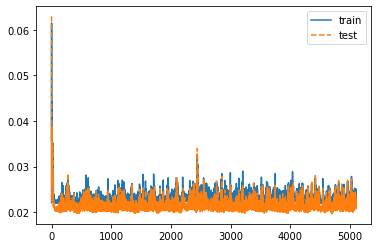

In [26]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [27]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.005)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.99219 | Loss: 0.022555098 |
| Epoch:   500 | Accuracy: 0.99121 | Loss: 0.019641472 |
| Epoch:  1000 | Accuracy: 0.99121 | Loss: 0.019658469 |
| Epoch:  1500 | Accuracy: 0.99121 | Loss: 0.019566366 |
| Epoch:  2000 | Accuracy: 0.99219 | Loss: 0.019591521 |
| Epoch:  2500 | Accuracy: 0.99121 | Loss: 0.019691017 |
| Epoch:  3000 | Accuracy: 0.99121 | Loss: 0.019645425 |
| Epoch:  3500 | Accuracy: 0.99121 | Loss: 0.019596215 |
| Epoch:  4000 | Accuracy: 0.99121 | Loss: 0.019668171 |
| Epoch:  4500 | Accuracy: 0.99121 | Loss: 0.019701680 |
| Epoch:  5000 | Accuracy: 0.99121 | Loss: 0.019521341 |
| Epoch:  5500 | Accuracy: 0.99121 | Loss: 0.019594871 |
Early stop.
Finished.


(5656, 0.019505299627780914)

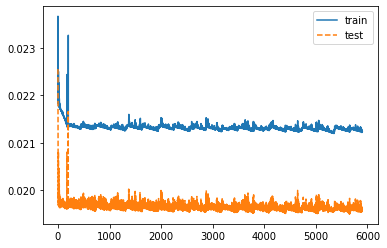

In [28]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [29]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [30]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Aging Aware PNN

In [31]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [32]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [33]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.14921 | Loss: 1.179166794 |
| Epoch:    12 | Accuracy: 0.80166 | Loss: 0.348861992 |
| Epoch:    24 | Accuracy: 0.86731 | Loss: 0.251348019 |
| Epoch:    36 | Accuracy: 0.89974 | Loss: 0.202005684 |
| Epoch:    48 | Accuracy: 0.90542 | Loss: 0.194561005 |
| Epoch:    60 | Accuracy: 0.92485 | Loss: 0.159567699 |
| Epoch:    72 | Accuracy: 0.91554 | Loss: 0.167936414 |
| Epoch:    84 | Accuracy: 0.92512 | Loss: 0.170581579 |
| Epoch:    96 | Accuracy: 0.91402 | Loss: 0.173177376 |
| Epoch:   108 | Accuracy: 0.92551 | Loss: 0.163363829 |
| Epoch:   120 | Accuracy: 0.91468 | Loss: 0.170925304 |
| Epoch:   132 | Accuracy: 0.93008 | Loss: 0.147830307 |
| Epoch:   144 | Accuracy: 0.92523 | Loss: 0.158026278 |
| Epoch:   156 | Accuracy: 0.90721 | Loss: 0.181015596 |
| Epoch:   168 | Accuracy: 0.92723 | Loss: 0.148341507 |
| Epoch:   180 | Accuracy: 0.93333 | Loss: 0.135636121 |
| Epoch:   192 | Accuracy: 0.91686 | Loss: 0.178361088 |
| Epoch:   204 | Accuracy: 0.93

(207, 0.12910623848438263)

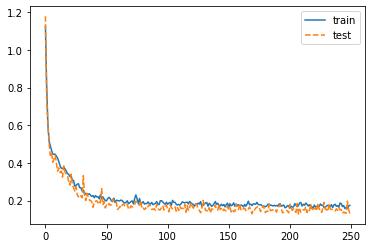

In [34]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [35]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=500, cache=ds)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.92643 | Loss: 0.154448375 |
| Epoch:    25 | Accuracy: 0.92668 | Loss: 0.151461929 |
| Epoch:    50 | Accuracy: 0.92113 | Loss: 0.162617579 |
| Epoch:    75 | Accuracy: 0.92168 | Loss: 0.157446727 |
| Epoch:   100 | Accuracy: 0.93537 | Loss: 0.128867134 |
| Epoch:   125 | Accuracy: 0.92423 | Loss: 0.149903297 |
| Epoch:   150 | Accuracy: 0.92973 | Loss: 0.161704406 |
| Epoch:   175 | Accuracy: 0.92419 | Loss: 0.146991998 |
| Epoch:   200 | Accuracy: 0.92667 | Loss: 0.148409441 |
| Epoch:   225 | Accuracy: 0.92742 | Loss: 0.145066842 |
| Epoch:   250 | Accuracy: 0.92310 | Loss: 0.155103609 |
| Epoch:   275 | Accuracy: 0.93338 | Loss: 0.138517693 |
| Epoch:   300 | Accuracy: 0.93267 | Loss: 0.135175392 |
| Epoch:   325 | Accuracy: 0.93375 | Loss: 0.136937484 |
| Epoch:   350 | Accuracy: 0.92194 | Loss: 0.156996727 |
| Epoch:   375 | Accuracy: 0.93483 | Loss: 0.137507662 |
| Epoch:   400 | Accuracy: 0.91990 | Loss: 0.170077965 |
| Epoch:   425 | Accuracy: 0.90

(459, 0.12403130531311035)

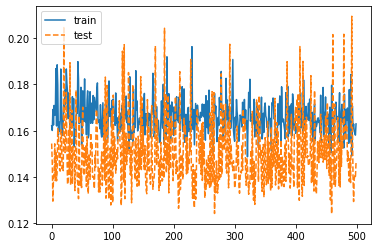

In [36]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [37]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=500, cache=ds)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.93176 | Loss: 0.143369347 |
| Epoch:    25 | Accuracy: 0.93755 | Loss: 0.129334271 |
| Epoch:    50 | Accuracy: 0.92671 | Loss: 0.147730187 |
| Epoch:    75 | Accuracy: 0.92409 | Loss: 0.154937416 |
| Epoch:   100 | Accuracy: 0.92166 | Loss: 0.151899412 |
| Epoch:   125 | Accuracy: 0.93383 | Loss: 0.134224743 |
| Epoch:   150 | Accuracy: 0.92916 | Loss: 0.143061578 |
| Epoch:   175 | Accuracy: 0.93118 | Loss: 0.138056338 |
| Epoch:   200 | Accuracy: 0.92206 | Loss: 0.156915963 |
| Epoch:   225 | Accuracy: 0.93339 | Loss: 0.135260791 |
| Epoch:   250 | Accuracy: 0.92953 | Loss: 0.153003559 |
| Epoch:   275 | Accuracy: 0.93298 | Loss: 0.140156865 |
| Epoch:   300 | Accuracy: 0.92695 | Loss: 0.168748930 |
| Epoch:   325 | Accuracy: 0.92917 | Loss: 0.143475562 |
| Epoch:   350 | Accuracy: 0.93617 | Loss: 0.129461825 |
| Epoch:   375 | Accuracy: 0.92846 | Loss: 0.149287179 |
| Epoch:   400 | Accuracy: 0.92276 | Loss: 0.158894688 |
| Epoch:   425 | Accuracy: 0.92

(362, 0.11854175478219986)

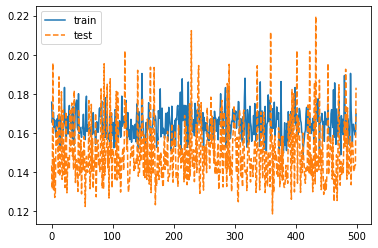

In [38]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [39]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)